# Background

This will use different simulation paradigms using the Epileptor on TVB framework. Meta data that is required comes from MRI, CT and DTI imaging, and parcellation framework to get:
* xyz coordinate seeg data = seeg.txt
* xyz coordinates of center of regions in parcellation = centres.txt
* structural connectivity matrix between all regions = weights.txt
* gain matrix to convert regions into seeg = gain_inv-square.txt / gain_inv-square.mat

In [10]:
%matplotlib inline
# %pylab nbagg
from tvb.simulator.lab import *
import os.path
from matplotlib import colors, cm
import time
import scipy.signal as sig

import numpy as np
import pandas as pd
import scipy.io

# downloaded library for peak detection in z time series
# import peakdetect

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
project_dir = "/media/ali39/TOSHIBA EXT/epilepsy_data/rawdata/_tng/id001_bt" 

## 1. Connectivity

Build out the connectivity matrix using the data from a specific patient.

In [11]:
con = connectivity.Connectivity.from_file(os.path.join(project_dir, "tvb/connectivity.zip"))

# set connectivity speed to instantaneous
con.speed = np.inf

# normalize weights
con.weights = con.weights/np.max(con.weights)
num_regions = len(con.region_labels)

print con
print "This patient has ", num_regions, " number of regions."
print "The connectivity matrix has shape: ", con.weights.shape

WARNING  File 'hemispheres' not found in ZIP.
Connectivity(bound=False, value=None)
This patient has  84  number of regions.
The connectivity matrix has shape:  (84, 84)


Text(0.5,0,'hi')

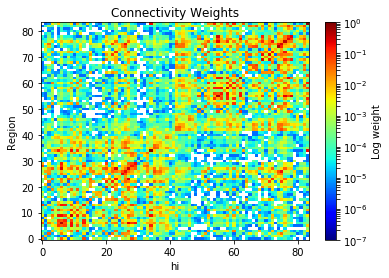

In [12]:
fig = plt.figure()
image = con.weights
norm = colors.LogNorm(1e-7, image.max()) #, clip='True')
plt.imshow(image, norm=norm, cmap=cm.jet, aspect='auto', origin='lower')
plt.title('Connectivity Weights')
plt.xlabel('Region'); plt.ylabel('Region')
cbar = plt.colorbar()
cbar.set_label('Log weight')
ax = plt.gca()
ax.set_xlabel('hi')

## 2. Model At Nodes of TVB

Here we define the computational model to use at each of the regions in TVB. For example, we will use the Epileptor. The variables used represent:
* z = slow permitivitty variable
* x2 = spike wave events
* y2 = spike wave events
* x1 = fast oscillations
* y1 = fast oscillations
* g = coupling integration
* Ks = permitivity coupling

Critical value of x0 is -2.05 for the epileptor model

In [13]:
epileptors = models.Epileptor(variables_of_interest=['x1', 'y1', 'z',\
                                                    'x2', 'y2', 'g',\
                                                    'x2-x1'])
epileptors.r = 1e-4

# permitivity coupling
epileptors.Ks = np.ones(num_regions)*(-1.0)*20.0

In [14]:
nez = np.arange(0,4)
npz = np.arange(0,4)

# Patient specific simulations
ez = [9]
pz = [6, 27]

x0ez = -1.8
x0pz = -2.05
x0norm = -2.3

epileptors.x0 = np.ones(num_regions) * x0norm
epileptors.x0[ez] = x0ez
epileptors.x0[pz] = x0pz

In [15]:
# define a simple difference coupling
coupl = coupling.Difference(a=1.)

## 3. Integrator for Model

This will define an integration scheme.

We will use a heun integration scheme that is more stable then an Euler scheme. We will use a stochastic integrator to create more realistic SEEG signals.

In [16]:
# define cov noise for the stochastic heun integrato
hiss = noise.Additive(nsig = numpy.array([0.01, 0.01, 0.,\
                                          0.00015, 0.00015, 0.]))
heunint = integrators.HeunStochastic(dt=0.04, noise=hiss)
heunintdet = integrators.HeunDeterministic(dt=0.04)

## 4. Create Monitors to Extract Signals From Simulation

These monitors are used to extract data say for:
* temporal averages of the epileptor time series at certain sampling rate (period=1.0 = 1000 Hz)
* seeg time series using xyz seeg contacts

In [17]:
# convert seeg.xyz to seeg.txt file
newsensorsfile = os.path.join(project_dir, "elec/seeg.txt")

# convert gain_inv-square.mat file into gain_inv-square.txt file
newgainmatfile = os.path.join(project_dir, "elec/gain_inv-square.txt")

In [18]:
mon_tavg = monitors.TemporalAverage(period=1.0)
mon_SEEG = monitors.iEEG.from_file(sensors_fname=newsensorsfile,
                    projection_fname=newgainmatfile,
                    period=1.0,
                    variables_of_interest=[6]
                )
num_contacts = mon_SEEG.sensors.labels.size

con.cortical[:] = True     # To avoid adding analytical gain matrix for subcortical sources

# initialize simulator object
sim = simulator.Simulator(model=epileptors,
                          connectivity=con,
                          coupling=coupl,
                          conduction_speed=float(con.speed[0]),
                          integrator=heunint,
                          monitors=[mon_tavg, mon_SEEG])
configs = sim.configure()

print "We have ", num_contacts, " SEEG contacts."
display(configs)

   INFO  Region simulation with 84 ROI nodes
   INFO  Memory requirement estimate: simulation will need about 0.5 MB
   INFO  White noise configured with dt=0.04
   INFO  Preparing initial history of shape (1, 6, 84, 1) using model.initial()
   INFO  Final initial history shape is (1, 6, 84, 1)
   INFO  history has n_time=1 n_cvar=2 n_node=84 n_nmode=1, requires 0.42 MB
   INFO  sparse history has n_nnzw=6460, i.e. 91.55 % sparse
   INFO  Projection configured gain shape (161, 84)
   INFO  Memory requirement census: simulation will need about 1.3 MB
We have  161  SEEG contacts.


Parameter,Value,Description
initial_conditions,None,"Initial conditions from which the simulation will begin. By default, random initial conditions are provided. Needs to be the same shape as simulator 'history', ie, initial history function which defines the minimal initial state of the network with time delays before time t=0. If the number of time points in the provided array is insufficient the array will be padded with random values based on the 'state_variables_range' attribute."
coupling,Difference(a=1),The coupling function is applied to the activity propagated between regions by the ``Long-range connectivity`` before it enters the local dynamic equations of the Model. Its primary purpose is to 'rescale' the incoming activity to a level appropriate to Model.
stimulus,None,"A ``Spatiotemporal stimulus`` can be defined at the region or surface level. It's composed of spatial and temporal components. For region defined stimuli the spatial component is just the strength with which the temporal component is applied to each region. For surface defined stimuli, a (spatial) function, with finite-support, is used to define the strength of the stimuli on the surface centred around one or more focal points. In the current version of TVB, stimuli are applied to the first state variable of the ``Local dynamic model``."
integrator,"HeunStochastic(dt=0.04, noise=Additive(dt=0.04, ntau=0))",A tvb.simulator.Integrator object which is an integration scheme with supporting attributes such as integration step size and noise specification for stochastic methods. It is used to compute the time courses of the model state variables.
surface,None,"By default, a Cortex object which represents the cortical surface defined by points in the 3D physical space and their neighborhood relationship. In the current TVB version, when setting up a surface-based simulation, the option to configure the spatial spread of the ``Local Connectivity`` is available."
connectivity,"Connectivity(bound=False, value=None)","A tvb.datatypes.Connectivity object which contains the structural long-range connectivity data (i.e., white-matter tracts). In combination with the ``Long-range coupling function`` it defines the inter-regional connections. These couplings undergo a time delay via signal propagation with a propagation speed of ``Conduction Speed``"
conduction_speed,inf,Conduction speed for ``Long-range connectivity`` (mm/ms)
simulation_length,1000.0,The length of a simulation (default in milliseconds).
model,"Epileptor(bound=False, value=None)","A tvb.simulator.Model object which describe the local dynamic equations, their parameters, and, to some extent, where connectivity (local and long-range) enters and which state-variables the Monitors monitor. By default the 'Generic2dOscillator' model is used. Read the Scientific documentation to learn more about this model."
monitors,"[TemporalAverage(bound=False, value=None), iEEG(bound=False, value=None)]","A tvb.simulator.Monitor or a list of tvb.simulator.Monitor objects that 'know' how to record relevant data from the simulation. Two main types exist: 1) simple, spatial and temporal, reductions (subsets or averages); 2) physiological measurements, such as EEG, MEG and fMRI. By default the Model's specified variables_of_interest are returned, temporally downsampled from the raw integration rate to a sample rate of 1024Hz."


In [19]:
# determine what the regions are for this certain parcellation
regions = configs.connectivity.region_labels

ezregion = np.array(['ctx-lh-cuneus', 'ctx-lh-bankssts'])
pzregion = []

sorter = np.argsort(regions)
ezindices = sorter[np.searchsorted(regions, ezregion, sorter=sorter)]
pzindices = sorter[np.searchsorted(regions, pzregion, sorter=sorter)]

print ezindices
print pzindices
print regions[ezindices]
print regions[pzindices]

# print start_time
# print elapsed
# print epileptors.tt
print configs.monitors[1]
# print mon_SEEG.sensors.locations

[3 0]
[]
['ctx-lh-cuneus' 'ctx-lh-bankssts']
[]
iEEG(period=1.000000, voi=[6])


## 5. Define Simulation Parameters

We will define paramters for simulation using simulation length.

In [ ]:
# 1000 = 1 second
samplerate = 1000 # Hz
sim_length = 10*samplerate

(epitimes, epilepts), (seegtimes, seegts) = sim.run(simulation_length=sim_length)

# understand the data output
print ts.shape # the region time series 
print tseeg.shape # the electrode time series
print epilepts.shape
print seegts.shape
print num_contacts
print num_regions

   INFO  Simulation runtime should be about 827.820 seconds
   INFO  Calculating storage requirement for ...
   INFO  Calculated storage requirement for simulation: 90720000 


In [79]:
# Save files
outputdir = os.path.join(root_dir, 'output/')
filename = os.path.join(outputdir, \
                patient+'_sim_ez'+str(len(ez))+'_pz'+str(len(pz))+'.npz')

In [85]:
meta = {'x0':{'x0ez':x0ez,'x0pz':x0pz,'x0norm':x0norm},
    'ez':con.region_labels[ez],
    'pz':con.region_labels[pz],
}
# save tseries
np.savez(filename, epitimes=ts, seegtimes=tseeg, epilepts=epilepts,\
        seegts=seegts, metadata=meta)

In [75]:
# Normalize the time series to have nice plots
tavgn = epilepts/(np.max(epilepts, 0) - np.min(epilepts, 0))
seegn = seegts/(np.max(seegts, 0) - np.min(seegts, 0))
seegn = seegn - np.mean(seegn, 0)

b, a = sig.butter(2, 0.1, btype='highpass', output='ba')
#seegf = sig.filtfilt(B, A, seegn)
seegf = np.zeros(seegn.shape)
for i in range(num_contacts):
    seegf[:, 0, i, 0] = sig.filtfilt(b, a, seegts[:, 0, i, 0])

In [87]:
data = np.load(filename)
print data.files
print data['metadata']

['epilepts', 'metadata', 'seegts', 'epitimes', 'seegtimes']
{'pz': array(['ctx-lh-inferiorparietal', 'ctx-lh-superiorparietal'],
      dtype='|S31'), 'x0': {'x0ez': -1.8, 'x0norm': -2.3, 'x0pz': -2.05}, 'ez': array(['ctx-lh-lateraloccipital'],
      dtype='|S31')}


# Visualization

In [ ]:
# understand the data output
print tavg.shape # the region time series 
print seeg.shape # the electrode time series
print num_contacts
print num_regions

In [ ]:
# Normalize the time series to have nice plots
tavgn = tavg/(np.max(tavg, 0) - np.min(tavg, 0))
seegn = seeg/(np.max(seeg, 0) - np.min(seeg, 0))
seegn = seegn - np.mean(seegn, 0)

In [ ]:
b, a = sig.butter(2, 0.1, btype='highpass', output='ba')
#seegf = sig.filtfilt(B, A, seegn)
seegf = np.zeros(seegn.shape)
for i in range(num_contacts):
    seegf[:, 0, i, 0] = sig.filtfilt(b, a, seeg[:, 0, i, 0])

In [ ]:
#Plot raw time series
figure(figsize=(9,10))

indf = 0
indt = -1

regf = 0
regt = 84

plot(ttavg[indf:indt], tavg[indf:indt, 6, regf:regt, 0]/4 + np.r_[regf:regt], 'r')
yticks(np.r_[regf:regt], con.region_labels[regf:regt])
title("Epileptors time series")
tight_layout()
show()   

In [ ]:
figure(figsize=(10,20))
plot(tseeg[:], seegn[:, 0, :, 0] + np.r_[:num_contacts])
yticks(np.r_[:num_contacts], mon_SEEG.sensors.labels[:])
title("SEEG")
tight_layout()

In [ ]:
figure(figsize=(10,20))
plot(tseeg[:], (seegn[:, 0, 1:num_contacts, 0] - seegn[:, 0, 0:num_contacts-1, 0]) + np.r_[:num_contacts-1])
yticks(np.r_[:num_contacts], mon_SEEG.sensors.labels[:])
title("SEEG")
tight_layout()

In [ ]:
figure(figsize=(10, 6))

electrodes = [("FCA'", 7), ("GL'", 7), ("CU'", 6), ("PP'", 1),
              ("PI'", 5), ("GC'", 8), ("PFG'", 10),
              ("OT'", 5), ("GPH'", 6), ("PFG", 10)]


for i, (el, num) in enumerate(electrodes):
    ind = np.where(mon_SEEG.sensors.labels == el + str(num))[0][0]
    plot(tseeg[:], (seegn[:, 0, ind, 0] - seegn[:, 0, ind - 1, 0])/0.5 + i)

labels = [el[0] + str(el[1]) + "-" + str(el[1] - 1) for el in electrodes]
yticks(np.r_[:len(electrodes)], labels)
tight_layout()

# Putting it All Together

Here, I put all the parts together to form a loop of simulations based on parameters I want to vary, specifically, we will want to vary:
* number of EZ regions
* number of PZ regions
* x0 paramters for the EZ region
* eventually the x0 paramters for the PZ region

In [14]:
# assuming onset is the first bifurcation and then every other one is onsets
# every other bifurcation after the first one is the offset
def findonsetoffset(zts):
    maxpeaks, minpeaks = peakdetect.peakdetect(zts)
    
    # get every other peaks
    onsettime, _ = zip(*maxpeaks)
    offsettime, _ = zip(*minpeaks)
    
    return onsettime, offsettime

def renamefiles(project_dir):
    # convert seeg.xyz to seeg.txt file
    sensorsfile = os.path.join(project_dir, "seeg.xyz")
    newsensorsfile = os.path.join(project_dir, "seeg.txt")
    try:
        os.rename(sensorsfile, newsensorsfile)
    except:
        print "Already renamed seeg.xyz possibly!"

    # convert gain_inv-square.mat file into gain_inv-square.txt file
    gainmatfile = os.path.join(project_dir, "gain_inv-square.mat")
    newgainmatfile = os.path.join(project_dir, "gain_inv-square.txt")
    try:
        os.rename(gainmatfile, newgainmatfile)
    except:
        print "Already renamed gain_inv-square.mat possibly!"
              
def setupsim(patient, ezloc, pzloc):
    # Patient specific simulations
    ez = ezloc
    pz = pzloc

    # bifurcation parameters in epileptor model
    x0ez = -1.8
    x0pz = -2.05
    x0norm = -2.3
    
    ## 1. Connectivity: initialize structural connectivity from dti imaging
    con = connectivity.Connectivity.from_file(os.path.join(project_dir, "connectivity.zip"))
    # set connectivity speed to instantaneous
    con.speed = np.inf

    # normalize weights
    con.weights = con.weights/np.max(con.weights)
    num_regions = len(con.region_labels)

    ## 2. Model: Define Epileptor model
    epileptors = models.Epileptor(variables_of_interest=['x2-x1', 'z'])
    # permitivity coupling
    epileptors.r = 1e-4
    epileptors.Ks = np.ones(num_regions)*(-1.0)*20.0

    epileptors.x0 = np.ones(num_regions) * x0norm
    epileptors.x0[ez] = x0ez
    epileptors.x0[pz] = x0pz

    # define a simple difference coupling
    coupl = coupling.Difference(a=1.)

    ## 3. Integrator: Define Huenstochastic Integrator for SDE
    # define cov noise for the stochastic heun integrato
    hiss = noise.Additive(nsig = numpy.array([0.01, 0.01, 0.,\
                                              0.00015, 0.00015, 0.]))
    heunint = integrators.HeunStochastic(dt=0.04, noise=hiss)
    heunintdet = integrators.HeunDeterministic(dt=0.04)

    ## 4. Monitor: Define monitors to extract simulated data
    mon_tavg = monitors.TemporalAverage(period=1.0)
    mon_SEEG = monitors.iEEG.from_file(sensors_fname=os.path.join(project_dir, "seeg.txt"),
                        projection_fname=os.path.join(project_dir, "gain_inv-square.txt"),
                        period=1.0,
                        variables_of_interest=[0]
                    )
    num_contacts = mon_SEEG.sensors.labels.size

    con.cortical[:] = True     # To avoid adding analytical gain matrix for subcortical sources

    ## 5. Run Simulation: initialize simulator object
    sim = simulator.Simulator(model=epileptors,
                              connectivity=con,
                              coupling=coupl,
                              conduction_speed=float(con.speed[0]),
                              integrator=heunint,
                              monitors=[mon_tavg, mon_SEEG])
    config = sim.configure()
    
    # 1000 = 1 second
    samplerate = 1000 # Hz
    sim_length = 60*samplerate

    # where to save simulated data
    outputdir = os.path.join(root_dir, 'output/')
    filename = os.path.join(outputdir, \
                    patient+'_sim_ez'+str(len(ez))+'_pz'+str(len(pz))+'.npz')
    
    # run simulation
    (epitimes, epilepts), \
        (seegtimes, seegts) = sim.run(simulation_length=sim_length)

    # get rid of beginning 5 seconds of simulation
    secstoreject = 5
    sampstoreject = secstoreject * samplerate
     
    # get the time series processed and squeezed that we want to save
    new_epitimes = epitimes[sampstoreject:]
    new_epilepts = epilepts[sampstoreject:, 0, :, :].squeeze().T
    new_seegtimes = seegtimes[sampstoreject:]
    new_seegts = seegts[sampstoreject:, :, :, :].squeeze().T
    zts = epilepts[sampstoreject:, 1, :].squeeze()
    onsettimes = None
    offsettimes = None
    try:
        onsettimes, offsettimes = findonsetoffset(zts[:,ezloc].squeeze())
    except:
        print "Still not working..."
        
    # Save files
    meta = {'x0':{'x0ez':x0ez,'x0pz':x0pz,'x0norm':x0norm},
        'ez':con.region_labels[ez],
        'pz':con.region_labels[pz],
        'onsettimes':onsettimes,
        'offsettimes':offsettimes,
        'patient':patient,
        'chanlabels':mon_SEEG.sensors.labels,
        'chanxyz': mon_SEEG.sensors.locations,
        'regionlabels':con.region_labels,
        'regionxyz':con.centres,
    }

    # save tseries
    np.savez(filename, epilepts=new_epilepts, seegts=new_seegts, times=new_seegts, \
         zts=zts, metadata=meta)

def runsim(sim, patient, ez, pz, root_dir):
    # 1000 = 1 second
    samplerate = 1000 # Hz
    sim_length = 60*samplerate

    # where to save simulated data
    outputdir = os.path.join(root_dir, 'output/')
    filename = os.path.join(outputdir, \
                    patient+'_sim_ez'+str(len(ez))+'_pz'+str(len(pz))+'.npz')

    # run simulation
    (epitimes, epilepts), \
        (seegtimes, seegts) = sim.run(simulation_length=sim_length)

    # get rid of beginning 5 seconds of simulation
    secstoreject = 5
    sampstoreject = secstoreject * samplerate
     
    # get the time series processed and squeezed that we want to save
    new_epitimes = epitimes[sampstoreject:]
    new_epilepts = epilepts[sampstoreject:, 0, :, :].squeeze().T
    new_seegtimes = seegtimes[sampstoreject:]
    new_seegts = seegts[sampstoreject:, :, :, :].squeeze().T
    zts = epilepts[sampstoreject:, 1, :].squeeze()
    onsettimes = None
    offsettimes = None
    try:
        onsettimes, offsettimes = findonsetoffset(zts[:,ezloc].squeeze())
    except:
        print "Still not working..."
        
    # Save files
    meta = {'x0':{'x0ez':x0ez,'x0pz':x0pz,'x0norm':x0norm},
        'ez':con.region_labels[ez],
        'pz':con.region_labels[pz],
        'onsettimes':onsettimes,
        'offsettimes':offsettimes,
        'patient':patient
    }

    # save tseries
    np.savez(filename, epilepts=new_epilepts, seegts=new_seegts, times=new_seegts, \
         zts=zts, metadata=meta)

In [15]:
patients=['id001_ac', 'id002_cj', 'id014_rb']
# patient='id001_ac'
gez = []
gpz = []
for patient in patients:
    print patient
    root_dir = os.getcwd()
    project_dir = os.path.join(root_dir, "metadata/"+patient)

    # rename metadata files necessary
    renamefiles(project_dir)
    sim = setupsim(patient, [], [])
#     runsim(sim, patient, gez, gpz, root_dir)

Gez = [[],[9],[0],[1],[2],[3]]
# Gpz = [[5,6,7,11,13,27,34,83],
#        [5,6,7,11,13,27,34,83],
#        [5,6,7,11,13,27,34,83],
#        [5,6,7,11,28,27,34,83]]
# Gpz = [[6, 27]]

# for i in range(0,4):
#     print i
#     gez = Gez[i]
#     gpz = Gpz[0]
    
#     simulatedata(patient, gez, gpz)

id001_ac
Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!
Still not working...
id002_cj
Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!
Still not working...
id014_rb
Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!
Still not working...


In [159]:
data = np.load(filename)
print data.keys()
for key in data.keys():
    print key
    print data[key].shape

['epilepts', 'metadata', 'seegts', 'zts', 'times']
epilepts
(5000, 84)
metadata
()
seegts
(5000, 70)
zts
(5000, 84)
times
(5000, 70)


In [168]:
print sim.monitors

[TemporalAverage(bound=False, value=None), iEEG(bound=False, value=None)]


<IPython.core.display.Javascript object>


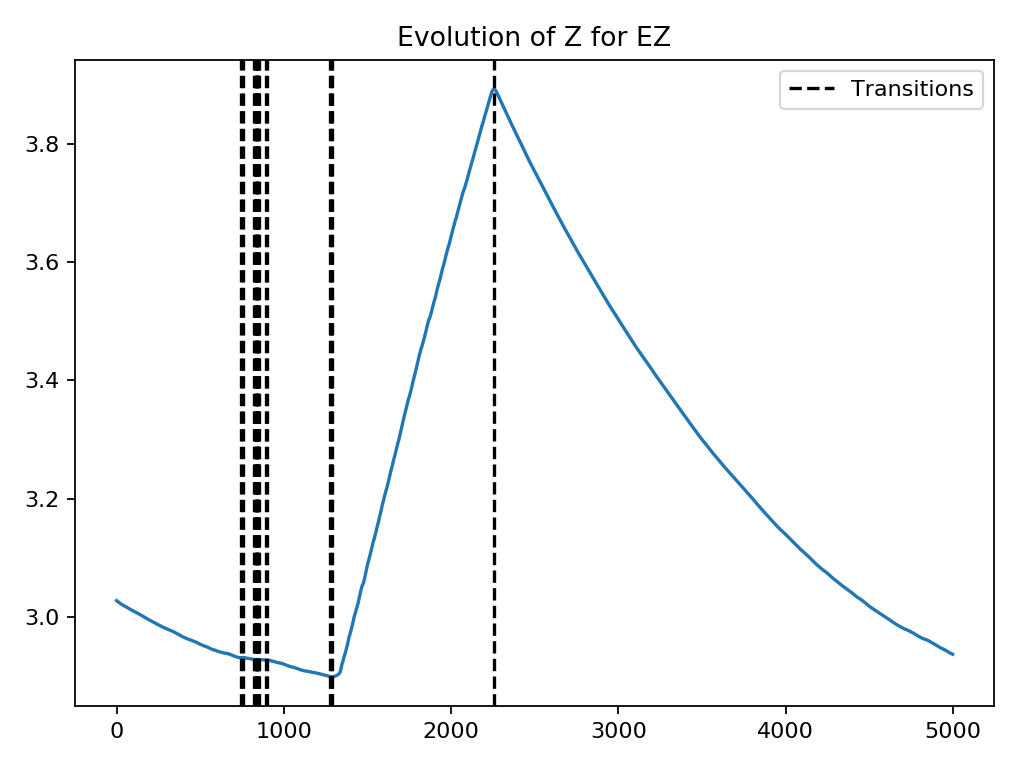

<IPython.core.display.Javascript object>


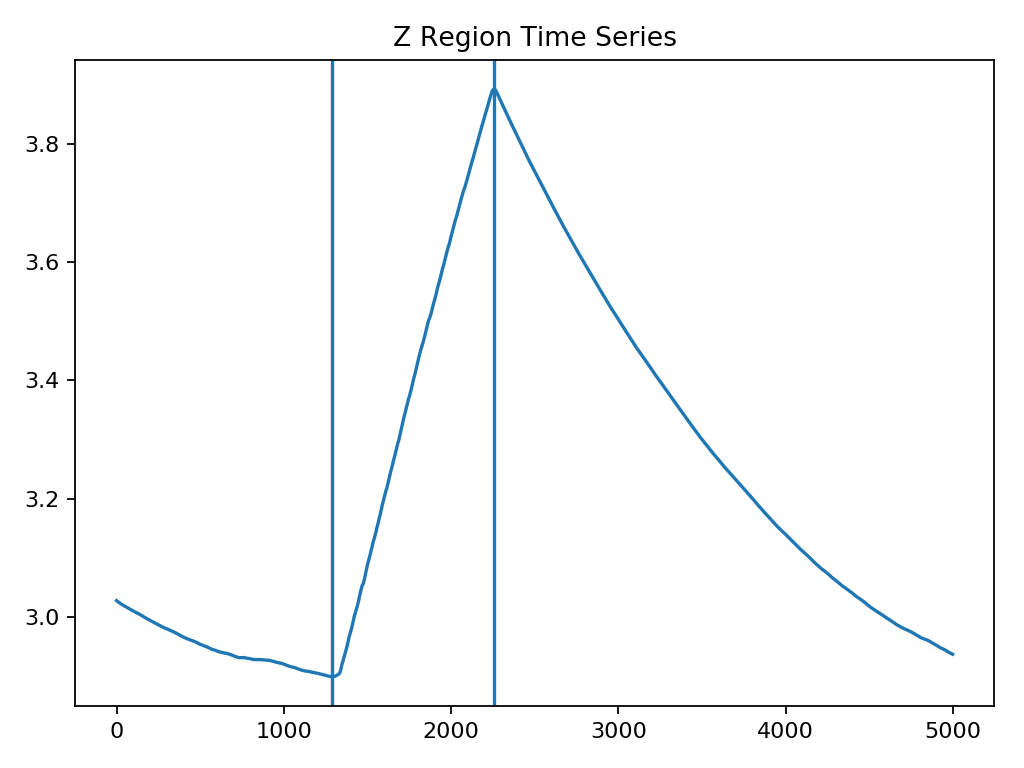

In [155]:
# keeping transitions
fig = plt.figure()
plt.plot(zts[:, ezloc])
for i in range(0, len(transitions)):
    a=plt.axvline(transitions[i], color='k', linestyle='--', label='Transitions')
plt.title('Evolution of Z for EZ')
plt.legend(handles=[a])
plt.tight_layout()

fig = plt.figure()
plt.plot(zts[:, ezloc].squeeze())
plt.title('Z Region Time Series')
plt.axvline(onsettimes)
plt.axvline(offsettimes)
plt.tight_layout()


# fig = plt.figure()
# plt.plot(zts[:, ezloc].squeeze())
# plt.title('Z Region Time Series')
# for i in range(0, len(peaks)):
#     plt.axvline(peaks[i][0][0])
# plt.tight_layout()


# fig = plt.figure()
# plt.plot(new_epilepts[:, 0, ezloc].squeeze())
# plt.title('EZ Region Time Series')
# plt.tight_layout()

# fig = plt.figure()
# plt.plot(epilepts[:, 0, ezloc].squeeze())
# plt.title('EZ Region Time Series')
# plt.tight_layout()

# fig = plt.figure()
# plt.plot(epilepts[:, 1, ezloc].squeeze())
# plt.title('EZ Region Time Series')
# # for i in range(0, len(peaks)):
# #     plt.axvline(peaks[i]+transitions[0])
# plt.tight_layout()
# fig = plt.figure()
# plt.plot(zts[:, 10])
# for i in range(0, len(transitions)):
#     plt.axvline(transitions[i])
# plt.tight_layout()

# fig = plt.figure()
# plt.plot(new_epilepts[transitions[len(transitions)-2]:transitions[-1]+10, 0, ezloc].squeeze())
# plt.tight_layout()

